# Lightweight CSPDNet Building and Training

In [1]:
!pip install thop

In [2]:
# Cell 1: Model Architecture and Training Code
import os
import time
import random
import shutil
import argparse
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import csv
import json
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms

#-------------------------------------------------------------------------------
# PART 1: MODEL ARCHITECTURE
#-------------------------------------------------------------------------------

class Conv(nn.Module):
    """Basic convolution layer"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=None, groups=1):
        super().__init__()
        if padding is None:
            padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False)
    
    def forward(self, x):
        return self.conv(x)

class BN(nn.Module):
    """Batch normalization layer"""
    def __init__(self, channels):
        super().__init__()
        self.bn = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        return self.bn(x)

class SiLU(nn.Module):
    """SiLU activation"""
    def __init__(self):
        super().__init__()
        self.silu = nn.SiLU()
    
    def forward(self, x):
        return self.silu(x)

class CBS(nn.Module):
    """Conv + BN (as shown in diagram)"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=None):
        super().__init__()
        if padding is None:
            padding = (kernel_size - 1) // 2
        self.conv = Conv(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = BN(out_channels)
    
    def forward(self, x):
        return self.bn(self.conv(x))

class ConvBNSiLU(nn.Module):
    """Conv + BN + SiLU (as shown in diagram)"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=None):
        super().__init__()
        if padding is None:
            padding = (kernel_size - 1) // 2
        self.conv = Conv(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = BN(out_channels)
        self.silu = SiLU()
    
    def forward(self, x):
        return self.silu(self.bn(self.conv(x)))

class LightDSC(nn.Module):
    """Lightweight Depthwise Separable Convolution Block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Depthwise convolution
        self.depthwise = Conv(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        # Pointwise convolution
        self.pointwise = Conv(in_channels, out_channels, kernel_size=1, stride=1)
        self.bn = BN(out_channels)
        self.act = nn.ReLU(inplace=True)  # Using ReLU instead of SiLU for efficiency
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class LightCSPBlock(nn.Module):
    """Lightweight Cross Stage Partial Block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        mid_channels = out_channels // 2
        
        # Main branch
        self.conv1 = Conv(in_channels, mid_channels, kernel_size=1)
        self.bn1 = BN(mid_channels)
        self.act1 = nn.ReLU(inplace=True)
        
        # Skip connection
        self.conv2 = Conv(in_channels, mid_channels, kernel_size=1)
        self.bn2 = BN(mid_channels)
        self.act2 = nn.ReLU(inplace=True)
        
        # Final 1x1 conv to combine features
        self.conv3 = Conv(mid_channels * 2, out_channels, kernel_size=1)
        self.bn3 = BN(out_channels)
        self.act3 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        # Main branch
        y1 = self.act1(self.bn1(self.conv1(x)))
        
        # Skip connection
        y2 = self.act2(self.bn2(self.conv2(x)))
        
        # Concat and final conv
        return self.act3(self.bn3(self.conv3(torch.cat([y1, y2], dim=1))))

class LightBackbone(nn.Module):
    """Lightweight backbone network"""
    def __init__(self, in_channels=3, base_channels=8):
        super().__init__()
        self.conv1 = ConvBNSiLU(in_channels, base_channels, kernel_size=3, stride=2)
        self.conv2 = ConvBNSiLU(base_channels, base_channels * 2, kernel_size=3, stride=2)
        self.csp1 = LightCSPBlock(base_channels * 2, base_channels * 2)
        
        self.conv3 = ConvBNSiLU(base_channels * 2, base_channels * 4, kernel_size=3, stride=2)
        self.csp2 = LightCSPBlock(base_channels * 4, base_channels * 4)
        
        self.conv4 = ConvBNSiLU(base_channels * 4, base_channels * 8, kernel_size=3, stride=2)
        self.csp3 = LightCSPBlock(base_channels * 8, base_channels * 8)
    
    def forward(self, x):
        features = []
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.csp1(x)
        features.append(x)  # First feature level (1/4 resolution)
        
        x = self.conv3(x)
        x = self.csp2(x)
        features.append(x)  # Second feature level (1/8 resolution)
        
        x = self.conv4(x)
        x = self.csp3(x)
        features.append(x)  # Third feature level (1/16 resolution)
        
        return features

class LightNeck(nn.Module):
    """Lightweight feature pyramid neck"""
    def __init__(self, channels_list):
        super().__init__()
        
        # Top-down pathway (from high-level to low-level features)
        self.td_conv1 = Conv(channels_list[2], channels_list[1], kernel_size=1)
        self.td_conv2 = Conv(channels_list[1], channels_list[0], kernel_size=1)
        
        # Process after feature fusion
        self.process1 = LightDSC(channels_list[1], channels_list[1])
        self.process2 = LightDSC(channels_list[0], channels_list[0])
        
        # Bottom-up pathway (from low-level to high-level)
        self.bu_conv1 = Conv(channels_list[0], channels_list[1], kernel_size=3, stride=2)
        self.bu_process1 = LightDSC(channels_list[1], channels_list[1])
        
        self.bu_conv2 = Conv(channels_list[1], channels_list[2], kernel_size=3, stride=2)
        self.bu_process2 = LightDSC(channels_list[2], channels_list[2])
    
    def forward(self, features):
        c0, c1, c2 = features
        
        # Top-down pathway
        p2 = c2
        
        p1_td = self.td_conv1(F.interpolate(p2, size=c1.shape[2:], mode='nearest'))
        p1 = self.process1(p1_td + c1)
        
        p0_td = self.td_conv2(F.interpolate(p1, size=c0.shape[2:], mode='nearest'))
        p0 = self.process2(p0_td + c0)
        
        # Bottom-up pathway
        p1_bu = self.bu_conv1(p0)
        p1 = self.bu_process1(p1 + p1_bu)
        
        p2_bu = self.bu_conv2(p1)
        p2 = self.bu_process2(p2 + p2_bu)
        
        return [p0, p1, p2]

class LightHead(nn.Module):
    """Lightweight classification head"""
    def __init__(self, channels_list, num_classes=10):
        super().__init__()
        
        # Global average pooling followed by FC
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Classification for each level
        self.classifiers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(channels, channels // 2, kernel_size=1),
                nn.BatchNorm2d(channels // 2),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels // 2, num_classes, kernel_size=1)
            ) for channels in channels_list
        ])
    
    def forward(self, features):
        cls_outputs = []
        
        for i, feature in enumerate(features):
            # Apply classifier
            cls_output = self.classifiers[i](feature)
            # Global average pooling to get scalar outputs per class
            cls_output = self.gap(cls_output).flatten(1)
            cls_outputs.append(cls_output)
        
        # Average predictions from different levels
        return sum(cls_outputs) / len(cls_outputs)

class LightCSPDModel(nn.Module):
    """Lightweight CSPD model for drone classification"""
    def __init__(self, in_channels=3, base_channels=8, num_classes=10):
        super().__init__()
        
        # Calculate channel dimensions for each level
        self.channels = [base_channels * 2, base_channels * 4, base_channels * 8]
        
        # Build network components
        self.backbone = LightBackbone(in_channels, base_channels)
        self.neck = LightNeck(self.channels)
        self.head = LightHead(self.channels, num_classes)
    
    def forward(self, x):
        # Extract features from backbone
        backbone_features = self.backbone(x)
        
        # Process through feature pyramid
        neck_features = self.neck(backbone_features)
        
        # Classification head
        return self.head(neck_features)

# Helper function to calculate model size
def calculate_model_size(model):
    """Calculate model size in MB and parameter count"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_mb = (param_size + buffer_size) / 1024**2
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    return {
        'model_size_mb': size_mb,
        'total_params': total_params,
        'trainable_params': trainable_params
    }

#-------------------------------------------------------------------------------
# PART 2: DATASET PREPARATION
#-------------------------------------------------------------------------------

def create_dataset_splits(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    """Splits the dataset into train, validation, and test sets."""
    random.seed(seed)
    np.random.seed(seed)
    
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    class_dirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    
    for class_name in class_dirs:
        class_path = os.path.join(source_dir, class_name)
        
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        
        image_files = []
        for root, _, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_files.append(os.path.join(root, file))
        
        random.shuffle(image_files)
        
        num_samples = len(image_files)
        num_train = int(train_ratio * num_samples)
        num_val = int(val_ratio * num_samples)
        
        train_files = image_files[:num_train]
        val_files = image_files[num_train:num_train + num_val]
        test_files = image_files[num_train + num_val:]
        
        for file in train_files:
            dst = os.path.join(train_dir, class_name, os.path.basename(file))
            shutil.copy(file, dst)
        
        for file in val_files:
            dst = os.path.join(val_dir, class_name, os.path.basename(file))
            shutil.copy(file, dst)
        
        for file in test_files:
            dst = os.path.join(test_dir, class_name, os.path.basename(file))
            shutil.copy(file, dst)
        
        print(f"Class {class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")
    
    return train_dir, val_dir, test_dir

class DroneDataset(Dataset):
    """Dataset class for the DIAT-uSAT drone dataset"""
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.samples = []
        for class_dir in self.root_dir.iterdir():
            if class_dir.is_dir():
                class_idx = self.class_to_idx[class_dir.name]
                for img_path in class_dir.glob('*.jpg'):
                    self.samples.append((str(img_path), class_idx))
                for img_path in class_dir.glob('*.png'):
                    self.samples.append((str(img_path), class_idx))
                for img_path in class_dir.glob('*.jpeg'):
                    self.samples.append((str(img_path), class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def get_data_loaders(train_dir, val_dir, test_dir, img_size=224, batch_size=32, num_workers=4):
    """Creates data loaders for train, validation, and test sets"""
    # Define transformations
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = DroneDataset(root_dir=train_dir, transform=train_transform)
    val_dataset = DroneDataset(root_dir=val_dir, transform=val_test_transform)
    test_dataset = DroneDataset(root_dir=test_dir, transform=val_test_transform)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=num_workers, pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=True
    )
    
    num_classes = len(train_dataset.classes)
    
    return train_loader, val_loader, test_loader, num_classes, train_dataset.classes

#-------------------------------------------------------------------------------
# PART 3: TRAINING FUNCTIONALITY
#-------------------------------------------------------------------------------

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward + optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': running_loss / total,
            'acc': 100. * correct / total
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validation", leave=False)
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': running_loss / total,
                'acc': 100. * correct / total
            })
    
    val_loss = running_loss / total
    val_acc = 100. * correct / total
    
    return val_loss, val_acc

def plot_training_history(train_losses, train_accs, val_losses, val_accs, save_path):
    """Plot and save training history"""
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# MAIN TRAINING FUNCTION
def train_model():
    # Set parameters
    base_channels = 8
    batch_size = 32
    img_size = 224
    epochs = 100
    lr = 0.001
    min_lr = 0.00001
    weight_decay = 0.01
    seed = 42
    num_workers = 4
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Set data directories - adjust as needed
    data_dir = "/kaggle/input/drone-usat/DIAT-uSAT_dataset"
    output_dir = "/kaggle/working/cspd_output"
    
    # Set random seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    print(f"Using device: {device}")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Check if dataset is already split
    if os.path.exists(os.path.join(output_dir, 'train')) and \
       os.path.exists(os.path.join(output_dir, 'val')) and \
       os.path.exists(os.path.join(output_dir, 'test')):
        print("Using existing dataset split...")
        train_dir = os.path.join(output_dir, 'train')
        val_dir = os.path.join(output_dir, 'val')
        test_dir = os.path.join(output_dir, 'test')
    else:
        print("Splitting dataset...")
        train_dir, val_dir, test_dir = create_dataset_splits(
            data_dir, output_dir, 
            train_ratio=0.8, 
            val_ratio=0.1, 
            test_ratio=0.1,
            seed=seed
        )
    
    # Create data loaders
    print("Creating data loaders...")
    train_loader, val_loader, test_loader, num_classes, class_names = get_data_loaders(
        train_dir, val_dir, test_dir, 
        img_size=img_size, 
        batch_size=batch_size, 
        num_workers=num_workers
    )
    
    print(f"Number of classes: {num_classes}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}")
    
    # Save class names
    with open(os.path.join(output_dir, "class_names.txt"), "w") as f:
        for name in class_names:
            f.write(f"{name}\n")
    
    # Initialize model
    print("Initializing model...")
    model = LightCSPDModel(in_channels=3, base_channels=base_channels, num_classes=num_classes)
    model = model.to(device)
    
    # Print model size
    model_stats = calculate_model_size(model)
    print(f"Model size: {model_stats['model_size_mb']:.4f} MB")
    print(f"Total parameters: {model_stats['total_params']:,}")
    print(f"Trainable parameters: {model_stats['trainable_params']:,}")
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=min_lr)
    
    # Training loop
    print("Starting training...")
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0
    
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        
        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update learning rate
        scheduler.step()
        
        # Print statistics
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Save best model (without early stopping)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'train_acc': train_acc,
                'num_classes': num_classes,
                'class_names': class_names
            }
            torch.save(checkpoint, os.path.join(output_dir, "best_model.pth"))
            print(f"Saved best model with validation accuracy: {val_acc:.2f}%")
        
        # Plot training history every 10 epochs
        if epoch % 10 == 0 or epoch == epochs:
            plot_training_history(
                train_losses, train_accs, val_losses, val_accs,
                os.path.join(output_dir, "training_history.png")
            )
    
    # Save final model
    final_checkpoint = {
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_acc': val_acc,
        'train_acc': train_acc,
        'num_classes': num_classes,
        'class_names': class_names
    }
    torch.save(final_checkpoint, os.path.join(output_dir, "final_model.pth"))
    print(f"Saved final model with validation accuracy: {val_acc:.2f}%")
    
    # Plot final training history
    plot_training_history(
        train_losses, train_accs, val_losses, val_accs,
        os.path.join(output_dir, "final_training_history.png")
    )
    
    # Save training history as JSON
    history = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }
    with open(os.path.join(output_dir, "training_history.json"), "w") as f:
        json.dump(history, f)
    
    print(f"Training completed. Best validation accuracy: {best_val_acc:.2f}%")
    print(f"Model and results saved to {output_dir}")

# Run the training
if __name__ == "__main__":
    train_model()

Using device: cuda
Splitting dataset...
Class Bird+mini-helicopter_1: 332 train, 41 val, 42 test
Class 3_long_blade_rotor: 639 train, 79 val, 81 test
Class drone_2: 348 train, 43 val, 44 test
Class Bird+mini-helicopter_2: 320 train, 40 val, 40 test
Class Bird: 640 train, 80 val, 80 test
Class 3_short_blade_rotor_1: 320 train, 40 val, 40 test
Class 3_short_blade_rotor_2: 320 train, 40 val, 40 test
Class RC plane_1: 320 train, 40 val, 40 test
Class drone_1: 320 train, 40 val, 40 test
Class RC plane_2: 320 train, 40 val, 40 test
Creating data loaders...
Number of classes: 10
Training samples: 3879
Validation samples: 483
Test samples: 487
Initializing model...
Model size: 0.2823 MB
Total parameters: 72,878
Trainable parameters: 72,878
Starting training...

Epoch 1/100


Train Loss: 1.7354, Train Acc: 48.93%
Val Loss: 1.2587, Val Acc: 57.56%
Learning Rate: 0.001000
Saved best model with validation accuracy: 57.56%

Epoch 2/100


Train Loss: 1.2025, Train Acc: 60.87%
Val Loss: 1.0261, Val Acc: 63.35%
Learning Rate: 0.000999
Saved best model with validation accuracy: 63.35%

Epoch 3/100


Train Loss: 0.9554, Train Acc: 67.08%
Val Loss: 0.9216, Val Acc: 65.84%
Learning Rate: 0.000998
Saved best model with validation accuracy: 65.84%

Epoch 4/100


Train Loss: 0.8134, Train Acc: 73.16%
Val Loss: 0.7834, Val Acc: 66.67%
Learning Rate: 0.000996
Saved best model with validation accuracy: 66.67%

Epoch 5/100


Train Loss: 0.6894, Train Acc: 76.93%
Val Loss: 0.6364, Val Acc: 78.05%
Learning Rate: 0.000994
Saved best model with validation accuracy: 78.05%

Epoch 6/100


Train Loss: 0.5897, Train Acc: 80.69%
Val Loss: 0.6813, Val Acc: 74.95%
Learning Rate: 0.000991

Epoch 7/100


Train Loss: 0.5072, Train Acc: 84.15%
Val Loss: 0.4535, Val Acc: 85.30%
Learning Rate: 0.000988
Saved best model with validation accuracy: 85.30%

Epoch 8/100


Train Loss: 0.4295, Train Acc: 86.52%
Val Loss: 0.4974, Val Acc: 81.16%
Learning Rate: 0.000984

Epoch 9/100


Train Loss: 0.3859, Train Acc: 87.73%
Val Loss: 0.4584, Val Acc: 82.40%
Learning Rate: 0.000980

Epoch 10/100


Train Loss: 0.3383, Train Acc: 88.53%
Val Loss: 0.2723, Val Acc: 90.89%
Learning Rate: 0.000976
Saved best model with validation accuracy: 90.89%

Epoch 11/100


Train Loss: 0.3081, Train Acc: 90.49%
Val Loss: 0.3736, Val Acc: 88.20%
Learning Rate: 0.000971

Epoch 12/100


Train Loss: 0.2763, Train Acc: 91.72%
Val Loss: 0.2569, Val Acc: 91.30%
Learning Rate: 0.000965
Saved best model with validation accuracy: 91.30%

Epoch 13/100


Train Loss: 0.2458, Train Acc: 92.16%
Val Loss: 0.2241, Val Acc: 93.58%
Learning Rate: 0.000959
Saved best model with validation accuracy: 93.58%

Epoch 14/100


Train Loss: 0.2430, Train Acc: 92.63%
Val Loss: 0.2642, Val Acc: 91.10%
Learning Rate: 0.000953

Epoch 15/100


Train Loss: 0.2113, Train Acc: 93.37%
Val Loss: 0.2477, Val Acc: 90.68%
Learning Rate: 0.000946

Epoch 16/100


Train Loss: 0.2229, Train Acc: 92.68%
Val Loss: 0.3293, Val Acc: 86.96%
Learning Rate: 0.000939

Epoch 17/100


Train Loss: 0.1752, Train Acc: 95.15%
Val Loss: 0.2583, Val Acc: 90.48%
Learning Rate: 0.000931

Epoch 18/100


Train Loss: 0.1585, Train Acc: 95.13%
Val Loss: 0.2218, Val Acc: 94.00%
Learning Rate: 0.000923
Saved best model with validation accuracy: 94.00%

Epoch 19/100


Train Loss: 0.1610, Train Acc: 95.15%
Val Loss: 0.2323, Val Acc: 92.13%
Learning Rate: 0.000914

Epoch 20/100


Train Loss: 0.1361, Train Acc: 95.77%
Val Loss: 0.1962, Val Acc: 95.03%
Learning Rate: 0.000905
Saved best model with validation accuracy: 95.03%

Epoch 21/100


Train Loss: 0.1409, Train Acc: 95.28%
Val Loss: 0.2895, Val Acc: 90.27%
Learning Rate: 0.000896

Epoch 22/100


Train Loss: 0.1223, Train Acc: 96.24%
Val Loss: 0.2291, Val Acc: 92.55%
Learning Rate: 0.000886

Epoch 23/100


Train Loss: 0.1320, Train Acc: 95.72%
Val Loss: 0.1761, Val Acc: 94.20%
Learning Rate: 0.000876

Epoch 24/100


Train Loss: 0.0961, Train Acc: 97.27%
Val Loss: 0.1842, Val Acc: 94.41%
Learning Rate: 0.000866

Epoch 25/100


Train Loss: 0.1020, Train Acc: 96.91%
Val Loss: 0.1539, Val Acc: 95.65%
Learning Rate: 0.000855
Saved best model with validation accuracy: 95.65%

Epoch 26/100


Train Loss: 0.1042, Train Acc: 96.65%
Val Loss: 0.2261, Val Acc: 91.10%
Learning Rate: 0.000844

Epoch 27/100


Train Loss: 0.1059, Train Acc: 96.70%
Val Loss: 0.1358, Val Acc: 96.48%
Learning Rate: 0.000832
Saved best model with validation accuracy: 96.48%

Epoch 28/100


Train Loss: 0.0829, Train Acc: 97.76%
Val Loss: 0.1688, Val Acc: 94.41%
Learning Rate: 0.000821

Epoch 29/100


Train Loss: 0.0810, Train Acc: 97.58%
Val Loss: 0.1465, Val Acc: 95.03%
Learning Rate: 0.000808

Epoch 30/100


Train Loss: 0.0734, Train Acc: 97.76%
Val Loss: 0.1493, Val Acc: 94.41%
Learning Rate: 0.000796

Epoch 31/100


Train Loss: 0.0696, Train Acc: 98.17%
Val Loss: 0.1643, Val Acc: 95.65%
Learning Rate: 0.000783

Epoch 32/100


Train Loss: 0.0791, Train Acc: 97.81%
Val Loss: 0.1475, Val Acc: 96.07%
Learning Rate: 0.000770

Epoch 33/100


Train Loss: 0.0803, Train Acc: 97.40%
Val Loss: 0.1532, Val Acc: 95.03%
Learning Rate: 0.000757

Epoch 34/100


Train Loss: 0.0692, Train Acc: 97.71%
Val Loss: 0.1727, Val Acc: 95.45%
Learning Rate: 0.000743

Epoch 35/100


Train Loss: 0.0647, Train Acc: 97.99%
Val Loss: 0.1582, Val Acc: 95.24%
Learning Rate: 0.000730

Epoch 36/100


Train Loss: 0.0552, Train Acc: 98.38%
Val Loss: 0.1771, Val Acc: 94.82%
Learning Rate: 0.000716

Epoch 37/100


Train Loss: 0.0380, Train Acc: 98.92%
Val Loss: 0.1407, Val Acc: 95.86%
Learning Rate: 0.000702

Epoch 38/100


Train Loss: 0.0677, Train Acc: 98.01%
Val Loss: 0.1599, Val Acc: 95.45%
Learning Rate: 0.000687

Epoch 39/100


Train Loss: 0.0617, Train Acc: 98.38%
Val Loss: 0.1513, Val Acc: 94.62%
Learning Rate: 0.000673

Epoch 40/100


Train Loss: 0.0574, Train Acc: 98.25%
Val Loss: 0.1221, Val Acc: 96.48%
Learning Rate: 0.000658

Epoch 41/100


Train Loss: 0.0531, Train Acc: 98.27%
Val Loss: 0.1526, Val Acc: 95.86%
Learning Rate: 0.000643

Epoch 42/100


Train Loss: 0.0432, Train Acc: 98.89%
Val Loss: 0.1399, Val Acc: 96.07%
Learning Rate: 0.000628

Epoch 43/100


Train Loss: 0.0387, Train Acc: 98.94%
Val Loss: 0.1476, Val Acc: 95.86%
Learning Rate: 0.000613

Epoch 44/100


Train Loss: 0.0303, Train Acc: 99.28%
Val Loss: 0.1327, Val Acc: 95.65%
Learning Rate: 0.000598

Epoch 45/100


Train Loss: 0.0439, Train Acc: 98.81%
Val Loss: 0.1387, Val Acc: 96.48%
Learning Rate: 0.000582

Epoch 46/100


Train Loss: 0.0257, Train Acc: 99.43%
Val Loss: 0.1336, Val Acc: 96.69%
Learning Rate: 0.000567
Saved best model with validation accuracy: 96.69%

Epoch 47/100


Train Loss: 0.0218, Train Acc: 99.56%
Val Loss: 0.1440, Val Acc: 96.07%
Learning Rate: 0.000552

Epoch 48/100


Train Loss: 0.0248, Train Acc: 99.33%
Val Loss: 0.1280, Val Acc: 96.07%
Learning Rate: 0.000536

Epoch 49/100


Train Loss: 0.0299, Train Acc: 99.51%
Val Loss: 0.1476, Val Acc: 95.45%
Learning Rate: 0.000521

Epoch 50/100


Train Loss: 0.0274, Train Acc: 99.30%
Val Loss: 0.1486, Val Acc: 95.24%
Learning Rate: 0.000505

Epoch 51/100


Train Loss: 0.0215, Train Acc: 99.59%
Val Loss: 0.1222, Val Acc: 96.27%
Learning Rate: 0.000489

Epoch 52/100


Train Loss: 0.0240, Train Acc: 99.51%
Val Loss: 0.1166, Val Acc: 96.69%
Learning Rate: 0.000474

Epoch 53/100


Train Loss: 0.0133, Train Acc: 99.77%
Val Loss: 0.1205, Val Acc: 96.27%
Learning Rate: 0.000458

Epoch 54/100


Train Loss: 0.0121, Train Acc: 99.77%
Val Loss: 0.1181, Val Acc: 97.10%
Learning Rate: 0.000443
Saved best model with validation accuracy: 97.10%

Epoch 55/100


Train Loss: 0.0379, Train Acc: 98.92%
Val Loss: 0.1285, Val Acc: 96.48%
Learning Rate: 0.000428

Epoch 56/100


Train Loss: 0.0323, Train Acc: 99.12%
Val Loss: 0.1081, Val Acc: 96.89%
Learning Rate: 0.000412

Epoch 57/100


Train Loss: 0.0188, Train Acc: 99.56%
Val Loss: 0.1025, Val Acc: 97.31%
Learning Rate: 0.000397
Saved best model with validation accuracy: 97.31%

Epoch 58/100


Train Loss: 0.0095, Train Acc: 99.90%
Val Loss: 0.1103, Val Acc: 97.31%
Learning Rate: 0.000382

Epoch 59/100


Train Loss: 0.0102, Train Acc: 99.85%
Val Loss: 0.1257, Val Acc: 97.10%
Learning Rate: 0.000367

Epoch 60/100


Train Loss: 0.0093, Train Acc: 99.87%
Val Loss: 0.1173, Val Acc: 96.89%
Learning Rate: 0.000352

Epoch 61/100


Train Loss: 0.0176, Train Acc: 99.54%
Val Loss: 0.1283, Val Acc: 97.31%
Learning Rate: 0.000337

Epoch 62/100


Train Loss: 0.0176, Train Acc: 99.72%
Val Loss: 0.1174, Val Acc: 97.72%
Learning Rate: 0.000323
Saved best model with validation accuracy: 97.72%

Epoch 63/100


Train Loss: 0.0105, Train Acc: 99.77%
Val Loss: 0.1427, Val Acc: 96.48%
Learning Rate: 0.000308

Epoch 64/100


Train Loss: 0.0088, Train Acc: 99.87%
Val Loss: 0.1135, Val Acc: 96.89%
Learning Rate: 0.000294

Epoch 65/100


Train Loss: 0.0076, Train Acc: 99.92%
Val Loss: 0.1162, Val Acc: 97.10%
Learning Rate: 0.000280

Epoch 66/100


Train Loss: 0.0152, Train Acc: 99.66%
Val Loss: 0.1252, Val Acc: 96.48%
Learning Rate: 0.000267

Epoch 67/100


Train Loss: 0.0146, Train Acc: 99.74%
Val Loss: 0.1392, Val Acc: 96.89%
Learning Rate: 0.000253

Epoch 68/100


Train Loss: 0.0071, Train Acc: 99.87%
Val Loss: 0.1182, Val Acc: 97.10%
Learning Rate: 0.000240

Epoch 69/100


Train Loss: 0.0064, Train Acc: 99.90%
Val Loss: 0.1144, Val Acc: 96.89%
Learning Rate: 0.000227

Epoch 70/100


Train Loss: 0.0065, Train Acc: 99.90%
Val Loss: 0.1160, Val Acc: 96.69%
Learning Rate: 0.000214

Epoch 71/100


Train Loss: 0.0086, Train Acc: 99.92%
Val Loss: 0.1297, Val Acc: 96.27%
Learning Rate: 0.000202

Epoch 72/100


Train Loss: 0.0042, Train Acc: 99.97%
Val Loss: 0.1081, Val Acc: 96.89%
Learning Rate: 0.000189

Epoch 73/100


Train Loss: 0.0066, Train Acc: 99.92%
Val Loss: 0.1154, Val Acc: 96.89%
Learning Rate: 0.000178

Epoch 74/100


Train Loss: 0.0048, Train Acc: 99.97%
Val Loss: 0.1128, Val Acc: 97.31%
Learning Rate: 0.000166

Epoch 75/100


Train Loss: 0.0065, Train Acc: 99.90%
Val Loss: 0.1181, Val Acc: 96.89%
Learning Rate: 0.000155

Epoch 76/100


Train Loss: 0.0037, Train Acc: 100.00%
Val Loss: 0.1242, Val Acc: 97.10%
Learning Rate: 0.000144

Epoch 77/100


Train Loss: 0.0037, Train Acc: 100.00%
Val Loss: 0.1199, Val Acc: 97.31%
Learning Rate: 0.000134

Epoch 78/100


Train Loss: 0.0044, Train Acc: 99.92%
Val Loss: 0.1307, Val Acc: 97.10%
Learning Rate: 0.000124

Epoch 79/100


Train Loss: 0.0035, Train Acc: 100.00%
Val Loss: 0.1217, Val Acc: 96.89%
Learning Rate: 0.000114

Epoch 80/100


Train Loss: 0.0029, Train Acc: 100.00%
Val Loss: 0.1266, Val Acc: 97.52%
Learning Rate: 0.000105

Epoch 81/100


Train Loss: 0.0034, Train Acc: 100.00%
Val Loss: 0.1203, Val Acc: 97.10%
Learning Rate: 0.000096

Epoch 82/100


Train Loss: 0.0026, Train Acc: 100.00%
Val Loss: 0.1279, Val Acc: 97.10%
Learning Rate: 0.000087

Epoch 83/100


Train Loss: 0.0029, Train Acc: 100.00%
Val Loss: 0.1233, Val Acc: 96.89%
Learning Rate: 0.000079

Epoch 84/100


Train Loss: 0.0029, Train Acc: 100.00%
Val Loss: 0.1199, Val Acc: 97.31%
Learning Rate: 0.000071

Epoch 85/100


Train Loss: 0.0040, Train Acc: 100.00%
Val Loss: 0.1244, Val Acc: 96.89%
Learning Rate: 0.000064

Epoch 86/100


Train Loss: 0.0035, Train Acc: 99.97%
Val Loss: 0.1288, Val Acc: 97.10%
Learning Rate: 0.000057

Epoch 87/100


Train Loss: 0.0038, Train Acc: 99.95%
Val Loss: 0.1481, Val Acc: 96.48%
Learning Rate: 0.000051

Epoch 88/100


Train Loss: 0.0029, Train Acc: 100.00%
Val Loss: 0.1302, Val Acc: 97.10%
Learning Rate: 0.000045

Epoch 89/100


Train Loss: 0.0028, Train Acc: 100.00%
Val Loss: 0.1286, Val Acc: 97.31%
Learning Rate: 0.000039

Epoch 90/100


Train Loss: 0.0036, Train Acc: 99.97%
Val Loss: 0.1335, Val Acc: 97.31%
Learning Rate: 0.000034

Epoch 91/100


Train Loss: 0.0032, Train Acc: 100.00%
Val Loss: 0.1376, Val Acc: 96.69%
Learning Rate: 0.000030

Epoch 92/100


Train Loss: 0.0029, Train Acc: 100.00%
Val Loss: 0.1272, Val Acc: 97.10%
Learning Rate: 0.000026

Epoch 93/100


Train Loss: 0.0032, Train Acc: 100.00%
Val Loss: 0.1353, Val Acc: 96.89%
Learning Rate: 0.000022

Epoch 94/100


Train Loss: 0.0029, Train Acc: 100.00%
Val Loss: 0.1306, Val Acc: 96.69%
Learning Rate: 0.000019

Epoch 95/100


Train Loss: 0.0027, Train Acc: 100.00%
Val Loss: 0.1284, Val Acc: 96.69%
Learning Rate: 0.000016

Epoch 96/100


Train Loss: 0.0028, Train Acc: 100.00%
Val Loss: 0.1324, Val Acc: 96.89%
Learning Rate: 0.000014

Epoch 97/100


Train Loss: 0.0025, Train Acc: 100.00%
Val Loss: 0.1285, Val Acc: 96.48%
Learning Rate: 0.000012

Epoch 98/100


Train Loss: 0.0029, Train Acc: 100.00%
Val Loss: 0.1243, Val Acc: 96.69%
Learning Rate: 0.000011

Epoch 99/100


Train Loss: 0.0024, Train Acc: 100.00%
Val Loss: 0.1278, Val Acc: 96.89%
Learning Rate: 0.000010

Epoch 100/100


Train Loss: 0.0023, Train Acc: 100.00%
Val Loss: 0.1300, Val Acc: 96.27%
Learning Rate: 0.000010
Saved final model with validation accuracy: 96.27%
Training completed. Best validation accuracy: 97.72%
Model and results saved to /kaggle/working/cspd_output


# Model Testing and Evaluation

Using device: cuda
Loading model from /kaggle/working/cspd_output/best_model.pth...


<ipython-input-3-3e58d0fe206a>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Loaded model with validation accuracy: 97.72%

Calculating model complexity (FLOPs, parameters, etc.)...

MODEL COMPLEXITY ANALYSIS
FLOPs: 36.795M (36,795,110.0)
MACs: 18.398M (18,397,555.0)
Parameters: 72.878K (72,878.0)
Inference time: 3.04 ms per image
FLOPs per parameter: 504.89
Time Complexity: O(N)
Computational Complexity Class: Linear - O(n)
Complexity Classification: Very Lightweight (Mobile-Friendly)

Comparison with common models:
  • MobileNetV2: ~0.3 GFLOPs
  • EfficientNet-B0: ~0.4 GFLOPs
  • ResNet-18: ~1.8 GFLOPs
  • ResNet-50: ~4.1 GFLOPs
  • VGG-16: ~15.5 GFLOPs
Test samples: 487


Testing: 100%|██████████| 16/16 [00:03<00:00,  4.13it/s]



Test Results:
  Accuracy: 96.30%
  Total inference time: 3.8814s
  Average inference time per sample: 7.97ms
  Average batch inference time: 11.30ms (std: 5.85ms)
  Batch time range: 5.11ms - 27.19ms

Overall Metrics:
  Precision: 0.9646
  Recall: 0.9630
  F1 Score: 0.9629

Per-class metrics:
  Class               Accuracy  Precision  Recall     F1 Score   Support
  ------------------------------------------------------------------
  3_long_blade_rotor  1.000000   0.931034   1.000000   0.964286   81.0
  3_short_blade_rotor_10.925000   0.925000   0.925000   0.925000   40.0
  3_short_blade_rotor_20.875000   1.000000   0.875000   0.933333   40.0
  Bird                1.000000   1.000000   1.000000   1.000000   80.0
  Bird+mini-helicopter_10.952381   0.888889   0.952381   0.919540   42.0
  Bird+mini-helicopter_20.900000   0.972973   0.900000   0.935065   40.0
  RC plane_1          0.950000   1.000000   0.950000   0.974359   40.0
  RC plane_2          1.000000   0.952381   1.000000   0.975

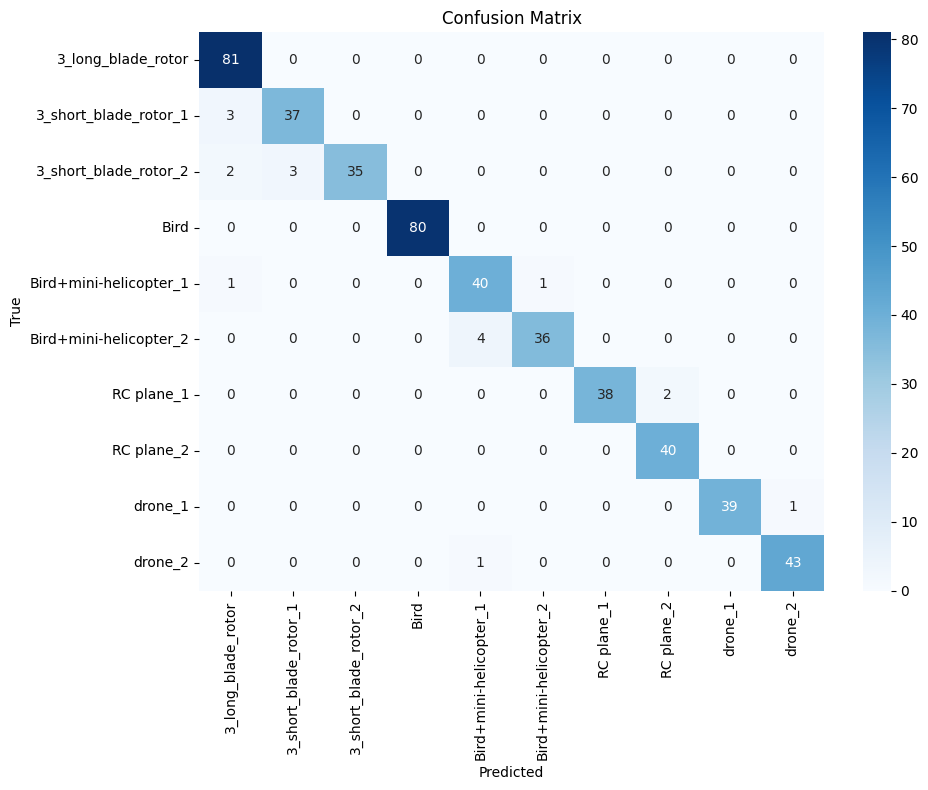

ROC curves saved to /kaggle/working/cspd_output/roc_curves.png


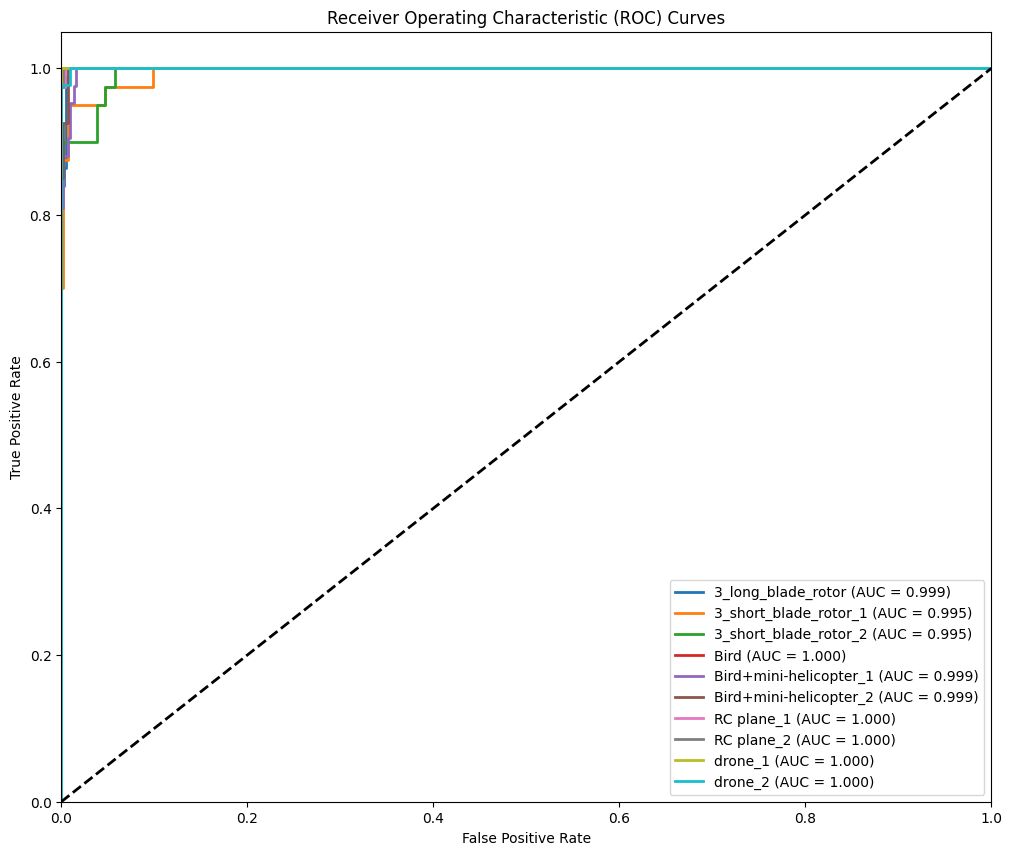

Zoomed ROC curves saved to /kaggle/working/cspd_output/roc_curves_zoomed.png


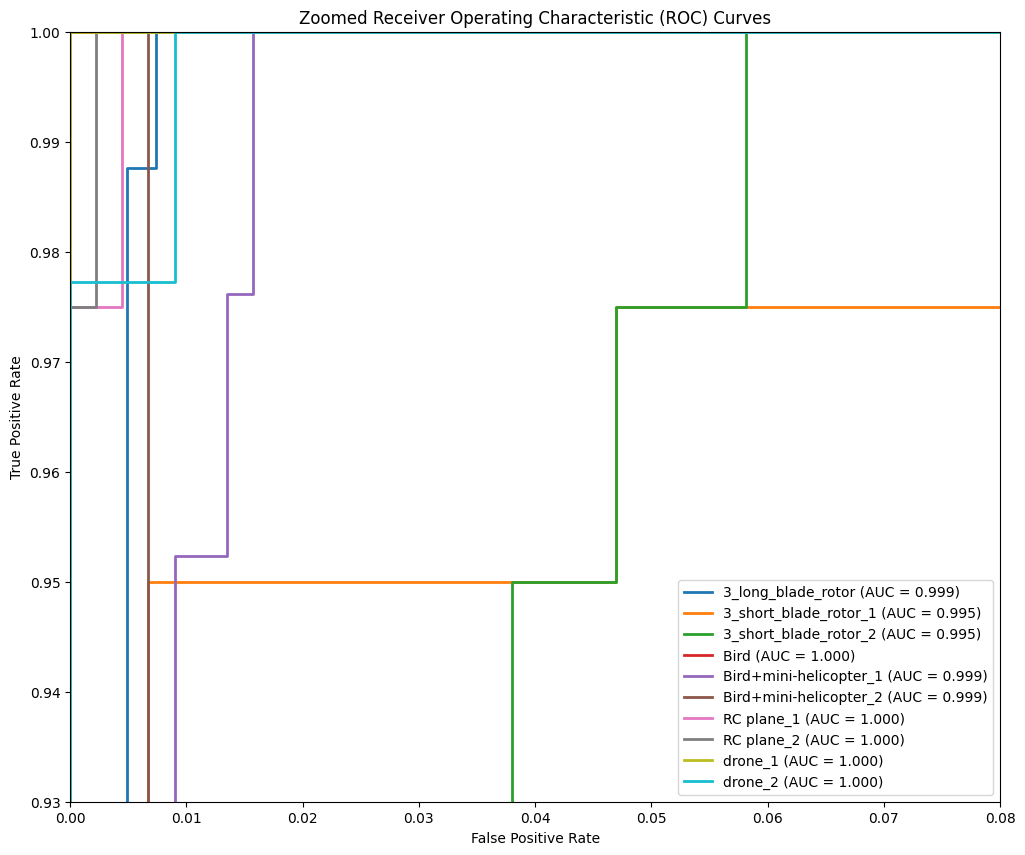

Precision-Recall curves saved to /kaggle/working/cspd_output/precision_recall_curves.png


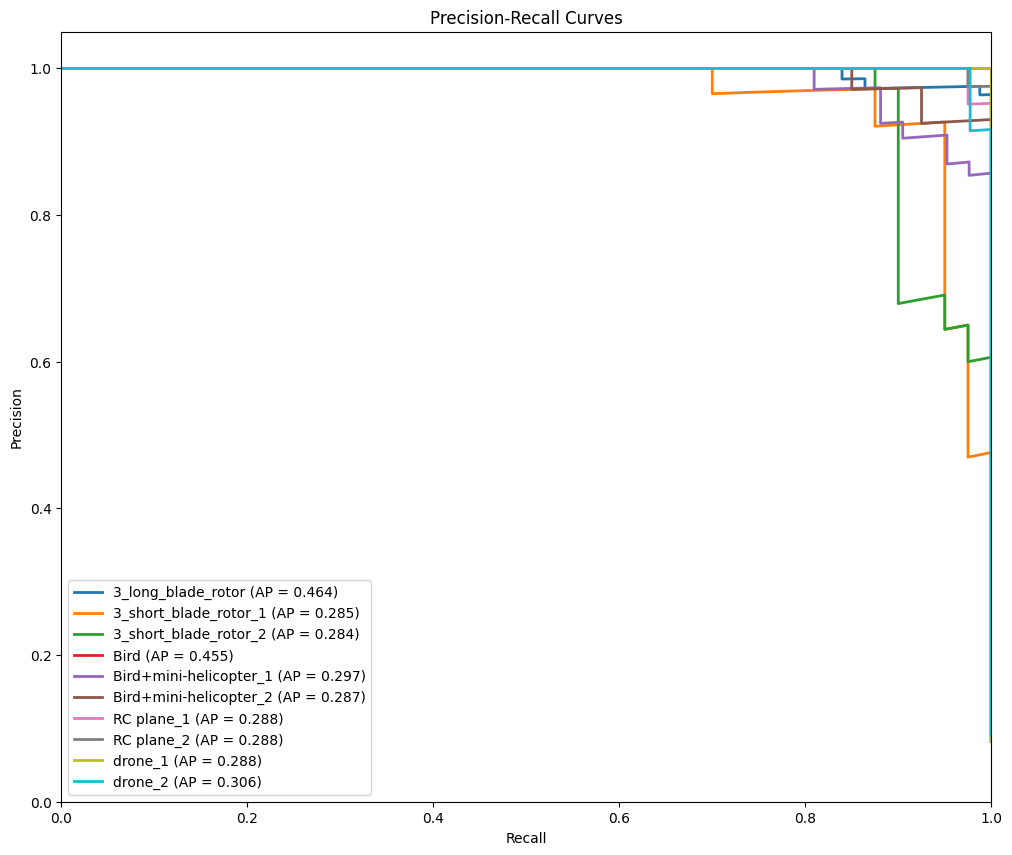


Evaluation completed. Results saved to /kaggle/working/cspd_output

Model Efficiency Summary:
  • FLOPs: 36.795M
  • Parameters: 72.878K
  • Inference Time: 3.04ms per image
  • Time Complexity: O(N)
  • Computational Complexity Class: Linear - O(n)

Classification Performance Summary:
  • Accuracy: 96.30%
  • Precision: 0.9646
  • Recall: 0.9630
  • F1 Score: 0.9629


In [3]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import json
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
# Import thop for FLOPs calculation
from thop import profile, clever_format
# Import for classification report
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
# Import for time complexity calculation
import time
import math

# Import model architecture from the first cell
# Note: In a Jupyter/Colab environment, you don't need to reimport 
# if the model architecture is already defined in previous cells

#-------------------------------------------------------------------------------
# PART 1: MODEL LOADING AND DATASET PREPARATION
#-------------------------------------------------------------------------------

def load_best_model(model_path, device):
    """Load the best model from checkpoint"""
    checkpoint = torch.load(model_path, map_location=device)
    num_classes = checkpoint['num_classes']
    class_names = checkpoint.get('class_names', None)
    
    # If class_names is not in the checkpoint, try to load them from a file
    if class_names is None and os.path.exists(os.path.join(os.path.dirname(model_path), "class_names.txt")):
        with open(os.path.join(os.path.dirname(model_path), "class_names.txt"), "r") as f:
            class_names = [line.strip() for line in f.readlines()]
    
    # Recreate the model
    model = LightCSPDModel(in_channels=3, base_channels=8, num_classes=num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    return model, class_names, checkpoint['val_acc']

def get_test_loader(test_dir, img_size=224, batch_size=32, num_workers=4):
    """Create test data loader"""
    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_dataset = DroneDataset(root_dir=test_dir, transform=test_transform)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=True
    )
    
    return test_loader, test_dataset.classes

#-------------------------------------------------------------------------------
# PART 2: MODEL COMPLEXITY CALCULATION FUNCTIONS
#-------------------------------------------------------------------------------

def calculate_model_complexity(model, img_size=224, device='cuda'):
    """
    Calculate model complexity metrics including FLOPs and parameters
    
    Args:
        model: PyTorch model
        img_size: Input image size
        device: Device to run calculation on
        
    Returns:
        dict: Dictionary with complexity metrics
    """
    # Create a dummy input tensor
    dummy_input = torch.randn(1, 3, img_size, img_size).to(device)
    
    # Use thop to profile the model
    flops, params = profile(model, inputs=(dummy_input,), verbose=False)
    
    # Calculate MACs (Multiply-Accumulate Operations, often considered as half of FLOPs)
    macs = flops / 2
    
    # Format numbers for better readability
    flops_readable, params_readable, macs_readable = clever_format([flops, params, macs], "%.3f")
    
    # Measure actual inference time
    start_time = time.time()
    with torch.no_grad():
        for _ in range(10):  # Average over multiple runs
            _ = model(dummy_input)
    inference_time = (time.time() - start_time) / 10 * 1000  # Convert to ms
    
    # Calculate efficiency metrics
    flops_per_param = flops / params if params > 0 else 0
    
    # Calculate theoretical time complexity
    # O(N) where N is the number of operations (FLOPs)
    time_complexity = "O(N)"  # Linear time complexity
    
    # Estimate computational complexity class based on number of operations
    if flops < 1e9:  # Less than 1 GFLOPs
        complexity_class = "Linear - O(n)"
    elif flops < 1e10:  # Less than 10 GFLOPs
        complexity_class = "Linearithmic - O(n log n)"
    else:
        complexity_class = "Quadratic or higher - O(n²) or higher"
    
    return {
        'flops': flops,
        'flops_readable': flops_readable,
        'macs': macs,
        'macs_readable': macs_readable,
        'params': params,
        'params_readable': params_readable,
        'inference_time_ms': inference_time,
        'flops_per_param': flops_per_param,
        'time_complexity': time_complexity,
        'complexity_class': complexity_class
    }

def print_model_complexity(complexity_metrics):
    """
    Print model complexity metrics in a readable format
    
    Args:
        complexity_metrics: Dictionary of complexity metrics
    """
    print("\n" + "="*50)
    print("MODEL COMPLEXITY ANALYSIS")
    print("="*50)
    
    print(f"FLOPs: {complexity_metrics['flops_readable']} ({complexity_metrics['flops']:,})")
    print(f"MACs: {complexity_metrics['macs_readable']} ({complexity_metrics['macs']:,})")
    print(f"Parameters: {complexity_metrics['params_readable']} ({complexity_metrics['params']:,})")
    print(f"Inference time: {complexity_metrics['inference_time_ms']:.2f} ms per image")
    print(f"FLOPs per parameter: {complexity_metrics['flops_per_param']:.2f}")
    print(f"Time Complexity: {complexity_metrics['time_complexity']}")
    print(f"Computational Complexity Class: {complexity_metrics['complexity_class']}")
    
    # Model complexity classification based on FLOPs
    if complexity_metrics['flops'] < 500_000_000:  # 0.5 GFLOPs
        complexity_class = "Very Lightweight (Mobile-Friendly)"
    elif complexity_metrics['flops'] < 2_000_000_000:  # 2 GFLOPs
        complexity_class = "Lightweight"
    elif complexity_metrics['flops'] < 10_000_000_000:  # 10 GFLOPs
        complexity_class = "Moderate"
    elif complexity_metrics['flops'] < 50_000_000_000:  # 50 GFLOPs
        complexity_class = "Heavy"
    else:
        complexity_class = "Very Heavy"
        
    print(f"Complexity Classification: {complexity_class}")
    
    # Comparison with common models
    print("\nComparison with common models:")
    print("  • MobileNetV2: ~0.3 GFLOPs")
    print("  • EfficientNet-B0: ~0.4 GFLOPs")
    print("  • ResNet-18: ~1.8 GFLOPs")
    print("  • ResNet-50: ~4.1 GFLOPs")
    print("  • VGG-16: ~15.5 GFLOPs")
    print("="*50)

#-------------------------------------------------------------------------------
# PART 3: EVALUATION FUNCTIONS
#-------------------------------------------------------------------------------

def test(model, dataloader, device, class_names=None):
    """Test the model and return detailed metrics"""
    model.eval()
    correct = 0
    total = 0
    
    # Store predictions and ground truth
    all_preds = []
    all_targets = []
    all_probs = []  # For ROC curve
    
    # Measure inference time
    start_time = time.time()
    
    # For calculating per-batch inference time
    batch_times = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Testing"):
            batch_start = time.time()
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward
            outputs = model(inputs)
            
            # Store probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            
            # Get predictions
            _, predicted = outputs.max(1)
            
            # Update statistics
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Store predictions and targets
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Record batch inference time
            batch_times.append(time.time() - batch_start)
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_probs = np.concatenate(all_probs, axis=0)
    
    # Calculate overall accuracy
    accuracy = 100 * correct / total
    
    # Calculate inference time
    inference_time = time.time() - start_time
    avg_time_per_sample = inference_time / total
    
    # Calculate batch statistics
    avg_batch_time = np.mean(batch_times)
    std_batch_time = np.std(batch_times)
    max_batch_time = np.max(batch_times)
    min_batch_time = np.min(batch_times)
    
    print(f"\nTest Results:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Total inference time: {inference_time:.4f}s")
    print(f"  Average inference time per sample: {avg_time_per_sample*1000:.2f}ms")
    print(f"  Average batch inference time: {avg_batch_time*1000:.2f}ms (std: {std_batch_time*1000:.2f}ms)")
    print(f"  Batch time range: {min_batch_time*1000:.2f}ms - {max_batch_time*1000:.2f}ms")
    
    # Calculate per-class metrics using sklearn
    precision = precision_score(all_targets, all_preds, average=None)
    recall = recall_score(all_targets, all_preds, average=None)
    f1 = f1_score(all_targets, all_preds, average=None)
    
    # Overall metrics
    overall_precision = precision_score(all_targets, all_preds, average='weighted')
    overall_recall = recall_score(all_targets, all_preds, average='weighted')
    overall_f1 = f1_score(all_targets, all_preds, average='weighted')
    
    print("\nOverall Metrics:")
    print(f"  Precision: {overall_precision:.4f}")
    print(f"  Recall: {overall_recall:.4f}")
    print(f"  F1 Score: {overall_f1:.4f}")
    
    # Calculate per-class accuracy
    class_accuracies = {}
    if class_names:
        class_correct = list(0. for _ in range(len(class_names)))
        class_total = list(0. for _ in range(len(class_names)))
        
        for pred, target in zip(all_preds, all_targets):
            class_correct[target] += int(pred == target)
            class_total[target] += 1
        
        print("\nPer-class metrics:")
        print("  Class               Accuracy  Precision  Recall     F1 Score   Support")
        print("  ------------------------------------------------------------------")
        for i, name in enumerate(class_names):
            if class_total[i] > 0:
                acc = 100 * class_correct[i] / class_total[i]
                class_accuracies[name] = acc
                print(f"  {name:<20}{acc/100:.6f}   {precision[i]:.6f}   {recall[i]:.6f}   {f1[i]:.6f}   {class_total[i]}")
    
    # Generate and print classification report
    if class_names:
        report = classification_report(all_targets, all_preds, target_names=class_names, digits=4)
        print("\nClassification Report:")
        print(report)
    
    return {
        'accuracy': accuracy,
        'inference_time': inference_time,
        'avg_time_per_sample': avg_time_per_sample,
        'class_accuracies': class_accuracies,
        'predictions': all_preds,
        'targets': all_targets,
        'probabilities': all_probs,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'overall_f1': overall_f1,
        'batch_times': {
            'avg': avg_batch_time,
            'std': std_batch_time,
            'min': min_batch_time,
            'max': max_batch_time
        }
    }

def plot_confusion_matrix(targets, predictions, class_names, save_path=None):
    """Plot and optionally save confusion matrix"""
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to {save_path}")
    
    plt.show()

def plot_roc_curves(targets, probabilities, class_names, save_path=None, save_zoomed_path=None):
    """Plot ROC curves for all classes and a zoomed version for high accuracy region"""
    n_classes = len(class_names)
    
    # Binarize the labels for multi-class ROC
    y_bin = label_binarize(targets, classes=range(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(12, 10))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    
    if save_path:
        plt.savefig(save_path)
        print(f"ROC curves saved to {save_path}")
    
    plt.show()
    
    # Plot zoomed ROC curve with the specified axis limits
    plt.figure(figsize=(12, 10))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 0.08])  # Updated: Zoom on x-axis from 0.0 to 0.08
    plt.ylim([0.93, 1.0])  # Updated: y-axis from 0.93 to 1.0
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Zoomed Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    
    if save_zoomed_path:
        plt.savefig(save_zoomed_path)
        print(f"Zoomed ROC curves saved to {save_zoomed_path}")
    
    plt.show()
    
    return roc_auc

# New function to plot precision-recall curves
def plot_precision_recall_curves(targets, probabilities, class_names, save_path=None):
    """Plot precision-recall curves for all classes"""
    n_classes = len(class_names)
    
    # Binarize the labels for multi-class precision-recall
    y_bin = label_binarize(targets, classes=range(n_classes))
    
    # Compute precision-recall curve and average precision for each class
    precision = dict()
    recall = dict()
    avg_precision = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], probabilities[:, i])
        # Calculate the area under the precision-recall curve
        avg_precision[i] = np.mean(precision[i])
    
    # Plot all precision-recall curves
    plt.figure(figsize=(12, 10))
    
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2,
                 label=f'{class_names[i]} (AP = {avg_precision[i]:.3f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc="best")
    
    if save_path:
        plt.savefig(save_path)
        print(f"Precision-Recall curves saved to {save_path}")
    
    plt.show()
    
    return avg_precision

#-------------------------------------------------------------------------------
# PART 4: MAIN TESTING FUNCTION WITH FLOPS CALCULATION
#-------------------------------------------------------------------------------

def run_evaluation():
    # Set parameters
    batch_size = 32
    img_size = 224
    num_workers = 4
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Set data directories - adjust as needed
    output_dir = "/kaggle/working/cspd_output"
    test_dir = os.path.join(output_dir, 'test')
    
    # Path to the saved model
    model_path = os.path.join(output_dir, "best_model.pth")
    
    print(f"Using device: {device}")
    
    # Load model
    print(f"Loading model from {model_path}...")
    model, class_names, best_val_acc = load_best_model(model_path, device)
    print(f"Loaded model with validation accuracy: {best_val_acc:.2f}%")
    
    # Calculate model complexity
    print("\nCalculating model complexity (FLOPs, parameters, etc.)...")
    complexity_metrics = calculate_model_complexity(model, img_size=img_size, device=device)
    print_model_complexity(complexity_metrics)
   
    # Create test loader
    test_loader, _ = get_test_loader(test_dir, img_size, batch_size, num_workers)
    print(f"Test samples: {len(test_loader.dataset)}")
    
    # Run test evaluation
    results = test(model, test_loader, device, class_names)
    
    # Plot confusion matrix
    plot_confusion_matrix(
        results['targets'], 
        results['predictions'], 
        class_names,
        save_path=os.path.join(output_dir, "confusion_matrix.png")
    )
    
    # Plot ROC curves
    roc_auc = plot_roc_curves(
        results['targets'], 
        results['probabilities'], 
        class_names,
        save_path=os.path.join(output_dir, "roc_curves.png"),
        save_zoomed_path=os.path.join(output_dir, "roc_curves_zoomed.png")
    )
    
    # Plot precision-recall curves
    avg_precision = plot_precision_recall_curves(
        results['targets'],
        results['probabilities'],
        class_names,
        save_path=os.path.join(output_dir, "precision_recall_curves.png")
    )
    
    # Save complexity results
    complexity_results = {
        'flops': int(complexity_metrics['flops']),
        'macs': int(complexity_metrics['macs']),
        'params': int(complexity_metrics['params']),
        'inference_time_ms': float(complexity_metrics['inference_time_ms']),
        'flops_per_param': float(complexity_metrics['flops_per_param']),
        'time_complexity': complexity_metrics['time_complexity'],
        'complexity_class': complexity_metrics['complexity_class']
    }
    
    # Save detailed classification metrics
    classification_metrics = {
        'overall': {
            'accuracy': float(results['accuracy']),
            'precision': float(results['overall_precision']),
            'recall': float(results['overall_recall']),
            'f1': float(results['overall_f1']),
        },
        'per_class': {}
    }
    
    for i, class_name in enumerate(class_names):
        classification_metrics['per_class'][class_name] = {
            'precision': float(results['precision'][i]),
            'recall': float(results['recall'][i]),
            'f1': float(results['f1'][i]),
            'auc': float(roc_auc[i]),
            'avg_precision': float(avg_precision[i])
        }
    
    # Save results
    evaluation_results = {
        'accuracy': results['accuracy'],
        'inference_time': results['inference_time'],
        'avg_time_per_sample_ms': results['avg_time_per_sample'] * 1000,
        'batch_times': {
            'avg_ms': results['batch_times']['avg'] * 1000,
            'std_ms': results['batch_times']['std'] * 1000,
            'min_ms': results['batch_times']['min'] * 1000,
            'max_ms': results['batch_times']['max'] * 1000
        },
        'class_accuracies': results['class_accuracies'],
        'roc_auc': {class_names[i]: roc_auc[i] for i in range(len(class_names))},
        'avg_precision': {class_names[i]: avg_precision[i] for i in range(len(class_names))},
        'classification_metrics': classification_metrics,
        'complexity': complexity_results  # Add complexity results
    }
    
    with open(os.path.join(output_dir, "evaluation_results.json"), "w") as f:
        json.dump(evaluation_results, f, indent=4)
    
    print(f"\nEvaluation completed. Results saved to {output_dir}")
    
    # Print out key complexity metrics again
    print("\nModel Efficiency Summary:")
    print(f"  • FLOPs: {complexity_metrics['flops_readable']}")
    print(f"  • Parameters: {complexity_metrics['params_readable']}")
    print(f"  • Inference Time: {complexity_metrics['inference_time_ms']:.2f}ms per image")
    print(f"  • Time Complexity: {complexity_metrics['time_complexity']}")
    print(f"  • Computational Complexity Class: {complexity_metrics['complexity_class']}")
    
    # Print overall classification metrics summary
    print("\nClassification Performance Summary:")
    print(f"  • Accuracy: {results['accuracy']:.2f}%")
    print(f"  • Precision: {results['overall_precision']:.4f}")
    print(f"  • Recall: {results['overall_recall']:.4f}")
    print(f"  • F1 Score: {results['overall_f1']:.4f}")
    
    return model, results, complexity_metrics

# Run the evaluation
if __name__ == "__main__":
    model, results, complexity = run_evaluation()

# Model summary and visualization


Generating Model Summary...

Detailed Model Summary:
Layer Type                               Output Shape              Param #        
--------------------------------------------------------------------------------
LightCSPDModel                           Unknown                   0              
backbone.LightBackbone                   Unknown                   0              
backbone.conv1.ConvBNSiLU                Unknown                   0              
backbone.conv1.conv.Conv                 Unknown                   0              
backbone.conv1.conv.conv.Conv2d          Unknown                   216            
backbone.conv1.bn.BN                     Unknown                   0              
backbone.conv1.bn.bn.BatchNorm2d         Unknown                   16             
backbone.conv1.silu.SiLU                 Unknown                   0              
backbone.conv1.silu.silu.SiLU            Unknown                   0              
backbone.conv2.ConvBNSiLU          

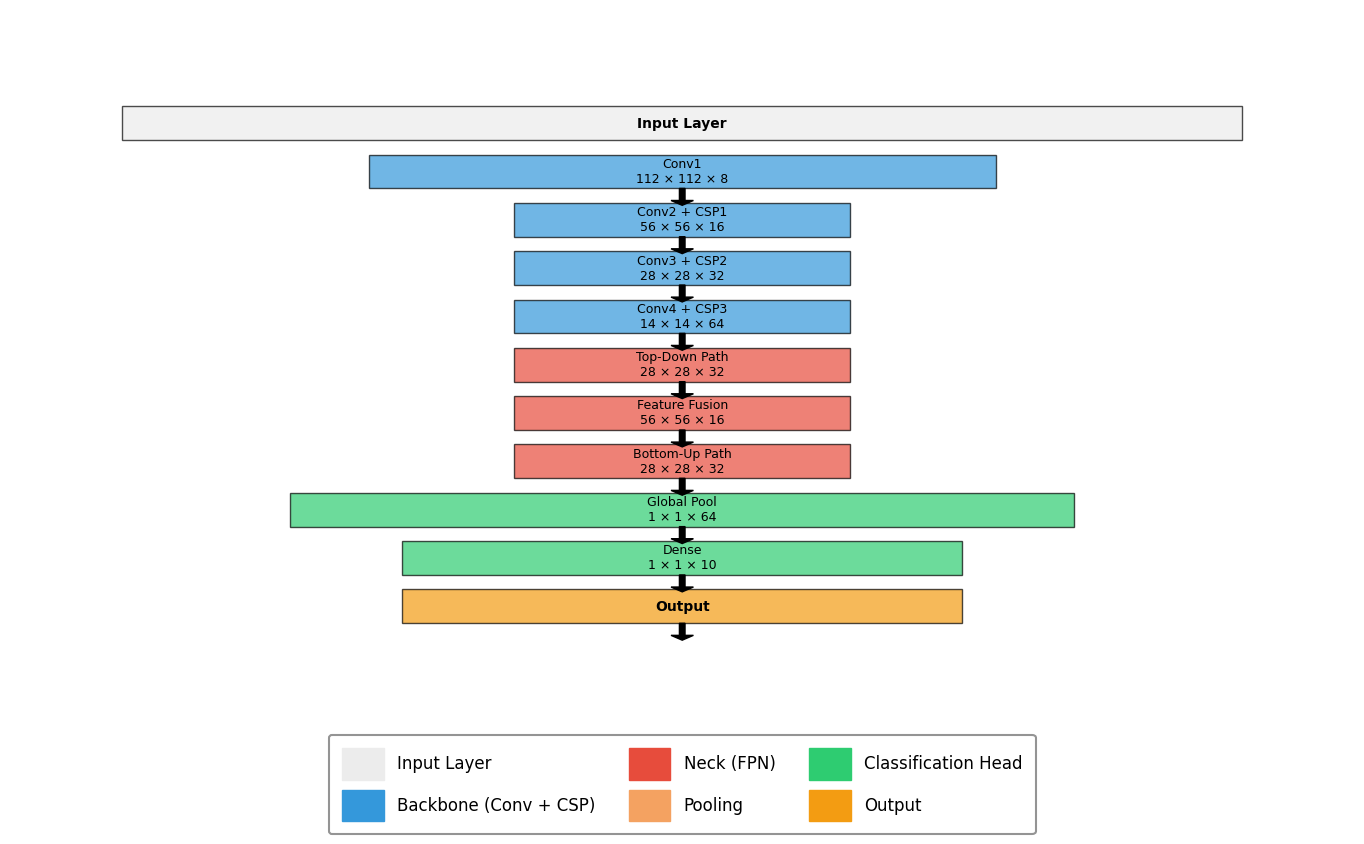


Generating Neural Network Diagram...
Neural network diagram saved to /kaggle/working/cspd_output/neural_network_diagram.png


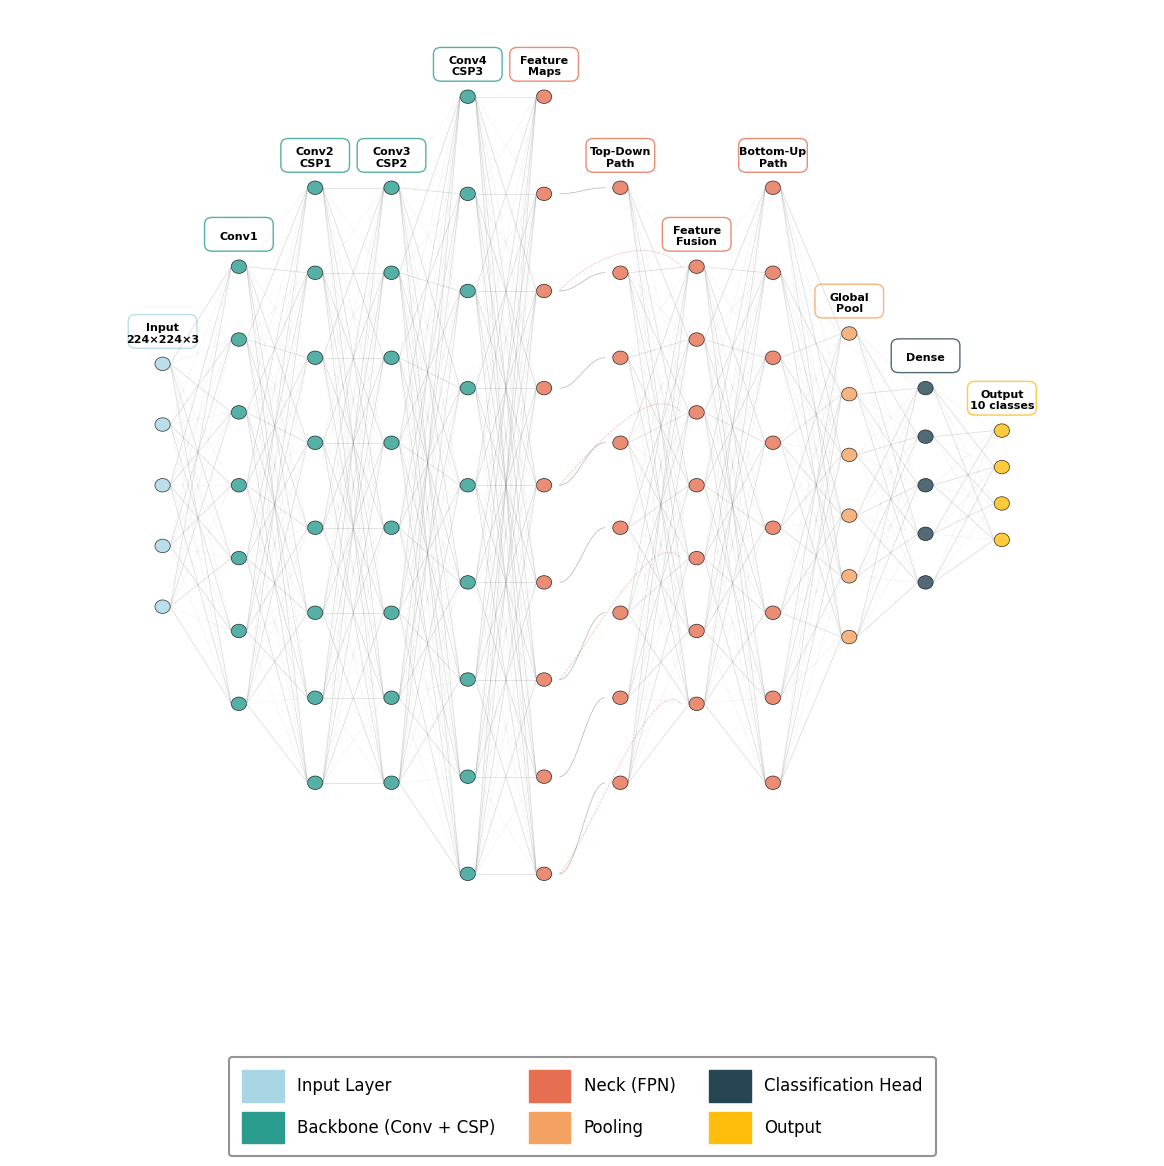


All visualizations saved to /kaggle/working/cspd_output


In [4]:
def custom_model_summary(model):
    """
    Create a custom model summary that works with complex architectures
    that have multiple inputs/outputs between layers
    """
    print("\nDetailed Model Summary:")
    print("=" * 80)
    print(f"{'Layer Type':<40} {'Output Shape':<25} {'Param #':<15}")
    print("-" * 80)
    
    def summarize_module(module, prefix=''):
        total_params = 0
        for name, param in module.named_parameters():
            if '.' not in name:  # Only direct parameters of this module
                total_params += param.numel()
        
        # Try to infer output shape for common layer types
        shape_str = "Unknown"
        
        # Print information about this module
        print(f"{prefix + module.__class__.__name__:<40} {shape_str:<25} {total_params:<15,}")
        
        # Recursively print information about child modules
        for name, child in module.named_children():
            child_prefix = f"{prefix}{name}."
            summarize_module(child, child_prefix)
            
    # Start from the top-level module
    summarize_module(model)
    
    # Print total parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)
    
    print("-" * 80)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")
    print(f"Non-trainable params: {total_params - trainable_params:,}")
    print(f"Model size in MB: {model_size_mb:.3f} MB")
    print(f"Model size in KB: {model_size_mb * 1024:.3f} KB")
    print("=" * 80)

def print_model_structure(model):
    """Print a text-based hierarchical representation of the model structure"""
    print("\nModel Structure:")
    print("=" * 80)
    
    def print_module(module, depth=0):
        indent = "  " * depth
        params = sum(p.numel() for p in module.parameters())
        print(f"{indent}├─ {module.__class__.__name__} ({params:,} params)")
        
        for name, child in module.named_children():
            print(f"{indent}│  └─ {name}:")
            print_module(child, depth + 2)
    
    print_module(model)
    print("=" * 80)

def create_detailed_nn_diagram(model, save_path=None):
    """
    Creates a detailed neural network diagram visualizing the connections
    between layers in a research-paper style presentation
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import matplotlib.path as mpath
    import numpy as np
    
    # Create figure with more margin space
    fig, ax = plt.subplots(figsize=(12, 12))  # Increased height to prevent cutoff
    
    # Set background color
    ax.set_facecolor('#f8f9fa')
    
    # Layer colors
    colors = {
        'input': '#a9d6e5',      # Light blue
        'conv': '#2a9d8f',       # Teal
        'feature': '#e76f51',    # Orange
        'pool': '#f4a261',       # Light orange
        'dense': '#264653',      # Dark blue
        'output': '#ffbe0b'      # Yellow
    }
    
    # Define the network architecture
    layers = [
        {'name': 'Input\n224×224×3', 'type': 'input', 'nodes': 5, 'width': 1.0},
        {'name': 'Conv1', 'type': 'conv', 'nodes': 7, 'width': 1.2},
        {'name': 'Conv2\nCSP1', 'type': 'conv', 'nodes': 8, 'width': 1.4},
        {'name': 'Conv3\nCSP2', 'type': 'conv', 'nodes': 8, 'width': 1.4},
        {'name': 'Conv4\nCSP3', 'type': 'conv', 'nodes': 9, 'width': 1.6},
        {'name': 'Feature\nMaps', 'type': 'feature', 'nodes': 9, 'width': 1.6, 'special': True},
        {'name': 'Top-Down\nPath', 'type': 'feature', 'nodes': 8, 'width': 1.4},
        {'name': 'Feature\nFusion', 'type': 'feature', 'nodes': 7, 'width': 1.2},
        {'name': 'Bottom-Up\nPath', 'type': 'feature', 'nodes': 8, 'width': 1.4},
        {'name': 'Global\nPool', 'type': 'pool', 'nodes': 6, 'width': 1.0},
        {'name': 'Dense', 'type': 'dense', 'nodes': 5, 'width': 0.8},
        {'name': 'Output\n10 classes', 'type': 'output', 'nodes': 4, 'width': 0.6}
    ]
    
    # Calculate layout with increased spacing
    layer_spacing = 1.0  # Horizontal spacing between layers
    node_spacing = 0.9   # Vertical spacing between nodes
    node_radius = 0.1    # Radius of each node
    
    # Calculate total width and height
    total_width = len(layers) * layer_spacing
    max_nodes = max(layer['nodes'] for layer in layers)
    total_height = max_nodes * node_spacing
    
    # Determine positions for each layer
    for i, layer in enumerate(layers):
        # Calculate x position (centered)
        layer['x'] = i * layer_spacing + layer_spacing / 2
        
        # Calculate node positions
        nodes = layer['nodes']
        layer['node_y'] = [
            total_height / 2 + (j - (nodes - 1) / 2) * node_spacing * layer['width']
            for j in range(nodes)
        ]
    
    # Draw connections between layers
    for i in range(len(layers) - 1):
        current_layer = layers[i]
        next_layer = layers[i + 1]
        
        # Special connections for feature pyramid
        if current_layer.get('special', False):
            # Draw connections from feature maps to multiple layers
            # This is a simplified representation of feature pyramid connections
            for j in range(min(len(current_layer['node_y']), len(next_layer['node_y']))):
                start_x = current_layer['x'] + node_radius * 2
                start_y = current_layer['node_y'][j]
                
                # Connect to next layer
                end_x = next_layer['x'] - node_radius * 2
                end_y = next_layer['node_y'][j]
                
                # Create a path with a curve
                path = mpath.Path(
                    [(start_x, start_y), 
                     (start_x + (end_x - start_x) * 0.4, start_y),
                     (start_x + (end_x - start_x) * 0.6, end_y),
                     (end_x, end_y)],
                    [mpath.Path.MOVETO, mpath.Path.CURVE4, mpath.Path.CURVE4, mpath.Path.CURVE4]
                )
                
                # Draw the path
                patch = patches.PathPatch(path, facecolor='none', edgecolor='gray', lw=0.5, alpha=0.6)
                ax.add_patch(patch)
                
            # Add skip connection to layer after next layer (feature pyramid concept)
            if i < len(layers) - 2:
                skip_layer = layers[i + 2]
                for j in range(min(len(current_layer['node_y']), len(skip_layer['node_y']))):
                    if j % 2 == 0:  # Skip some connections for clarity
                        start_x = current_layer['x'] + node_radius * 2
                        start_y = current_layer['node_y'][j]
                        
                        # Connect to skip layer
                        end_x = skip_layer['x'] - node_radius * 2
                        end_y = skip_layer['node_y'][j]
                        
                        # Create a curved path
                        path = mpath.Path(
                            [(start_x, start_y), 
                             (start_x + (end_x - start_x) * 0.25, start_y + 0.5),
                             (start_x + (end_x - start_x) * 0.75, end_y + 0.5),
                             (end_x, end_y)],
                            [mpath.Path.MOVETO, mpath.Path.CURVE4, mpath.Path.CURVE4, mpath.Path.CURVE4]
                        )
                        
                        # Draw the path
                        patch = patches.PathPatch(path, facecolor='none', edgecolor='#e74c3c', 
                                                lw=0.5, alpha=0.4, linestyle='--')
                        ax.add_patch(patch)
        else:
            # Regular connections between adjacent layers
            for start_idx, start_y in enumerate(current_layer['node_y']):
                for end_idx, end_y in enumerate(next_layer['node_y']):
                    # Connect with reduced opacity for cleaner look
                    opacity = 0.1
                    if start_idx % 2 == end_idx % 2:  # Only connect some nodes for clarity
                        opacity = 0.3
                    
                    # Draw connection line
                    ax.plot(
                        [current_layer['x'] + node_radius, next_layer['x'] - node_radius],
                        [start_y, end_y],
                        color='gray', linewidth=0.5, alpha=opacity
                    )
    
    # Draw nodes for each layer
    for layer in layers:
        for y_pos in layer['node_y']:
            # Create circle for each node
            circle = patches.Circle(
                (layer['x'], y_pos), node_radius,
                facecolor=colors[layer['type']], edgecolor='black', lw=0.5, alpha=0.8
            )
            ax.add_patch(circle)
        
        # Add layer name above the nodes with minimal padding
        top_y = max(layer['node_y']) + node_spacing / 2
        
        # Create a FancyBboxPatch for the layer name with minimal padding
        ax.add_patch(patches.FancyBboxPatch(
            (layer['x'] - 0.35, top_y - 0.12), 0.7, 0.3,  # Reduced size
            boxstyle=patches.BoxStyle("round", pad=0.1),  # Reduced padding
            facecolor='white', edgecolor=colors[layer['type']], lw=1, alpha=0.8
        ))
        
        # Add the text
        ax.text(
            layer['x'], top_y, layer['name'],
            horizontalalignment='center', verticalalignment='center',
            fontsize=8,  # Reduced font size
            color='black', fontweight='bold'
        )
    
    # Removed model statistics box as requested
    
    # Add legend with larger boxes
    handles = [
        patches.Patch(color=colors['input'], label='Input Layer'),
        patches.Patch(color=colors['conv'], label='Backbone (Conv + CSP)'),
        patches.Patch(color=colors['feature'], label='Neck (FPN)'),
        patches.Patch(color=colors['pool'], label='Pooling'),
        patches.Patch(color=colors['dense'], label='Classification Head'),
        patches.Patch(color=colors['output'], label='Output')
    ]
    
    # Position legend at the bottom with much larger boxes
    legend = ax.legend(
        handles=handles, 
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.02),
        ncol=3, 
        fontsize=12,  # Increased font size
        frameon=True,
        framealpha=0.9,
        edgecolor='#888888',
        handlelength=2.5,     # Increased size of color boxes
        handleheight=2.5,     # Increased size of color boxes
        borderpad=0.8,        # More padding inside legend border
        labelspacing=0.6      # More vertical spacing between legend entries
    )
    legend.get_frame().set_linewidth(1.5)  # Thicker border
    
    # Set limits with increased margins for overall diagram
    margin = 1.5  # Increased margin around the diagram
    ax.set_xlim(-margin, total_width + margin)
    ax.set_ylim(-4, total_height + 3)  # Extra space for larger legend at bottom
    
    # Remove axes
    ax.axis('off')
    
    # Add extra padding around the entire figure
    plt.tight_layout(pad=2.0)  # Add padding around the entire figure
    
    # Save figure with extra padding
    if save_path:
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches='tight', pad_inches=0.7)
        print(f"Neural network diagram saved to {save_path}.png")
    else:
        plt.savefig("nn_diagram.png", dpi=300, bbox_inches='tight', pad_inches=0.7)
        print("Neural network diagram saved to nn_diagram.png")
    
    plt.show()
    return fig

def visualize_keras_style(model, save_path=None):
    """
    Create a visualization similar to VisualKeras showing layers
    as colored blocks with proper dimensions and connections
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import numpy as np
    
    # Get model layers
    layers = []
    
    def extract_layers(module, prefix=''):
        # Start with backbone
        if isinstance(module, LightBackbone):
            layers.append({
                'name': 'Input Layer', 
                'type': 'input',
                'shape': [224, 224, 3],
                'color': '#ececec'
            })
            
            # Add conv layers
            layers.append({
                'name': 'Conv1', 
                'type': 'conv',
                'shape': [112, 112, 8],
                'color': '#3498db'
            })
            
            layers.append({
                'name': 'Conv2 + CSP1', 
                'type': 'conv',
                'shape': [56, 56, 16],
                'color': '#3498db'
            })
            
            layers.append({
                'name': 'Conv3 + CSP2', 
                'type': 'conv',
                'shape': [28, 28, 32],
                'color': '#3498db'
            })
            
            layers.append({
                'name': 'Conv4 + CSP3', 
                'type': 'conv',
                'shape': [14, 14, 64],
                'color': '#3498db'
            })
            
        # Add neck layers
        elif isinstance(module, LightNeck):
            layers.append({
                'name': 'Top-Down Path', 
                'type': 'feature',
                'shape': [28, 28, 32],
                'color': '#e74c3c'
            })
            
            layers.append({
                'name': 'Feature Fusion', 
                'type': 'feature',
                'shape': [56, 56, 16],
                'color': '#e74c3c'
            })
            
            layers.append({
                'name': 'Bottom-Up Path', 
                'type': 'feature',
                'shape': [28, 28, 32],
                'color': '#e74c3c'
            })
            
        # Add head layers
        elif isinstance(module, LightHead):
            layers.append({
                'name': 'Global Pool', 
                'type': 'pool',
                'shape': [1, 1, 64],
                'color': '#2ecc71'
            })
            
            num_classes = module.classifiers[0][-1].out_channels
            layers.append({
                'name': 'Dense', 
                'type': 'dense',
                'shape': [1, 1, num_classes],
                'color': '#2ecc71'
            })
            
            layers.append({
                'name': 'Output', 
                'type': 'output',
                'shape': [num_classes],
                'color': '#f39c12'
            })
        
        # Process children recursively
        for name, child in module.named_children():
            extract_layers(child, f"{prefix}.{name}" if prefix else name)
    
    # Extract layers
    extract_layers(model)
    
    # Remove duplicates (keeping the first occurrence)
    unique_layers = []
    layer_names = set()
    for layer in layers:
        if layer['name'] not in layer_names:
            unique_layers.append(layer)
            layer_names.add(layer['name'])
    
    layers = unique_layers
    
    # Create figure
    fig_height = max(8, len(layers) * 0.8)
    fig, ax = plt.subplots(figsize=(14, fig_height))  # Increased width for more margin
    
    # Settings
    layer_height = 0.7
    layer_spacing = 0.3
    max_layer_width = 10
    
    # Calculate total height needed
    total_height = len(layers) * (layer_height + layer_spacing) - layer_spacing
    
    # Convert reversed layers to a list first
    reversed_layers = list(reversed(layers))
    
    # Draw layers
    for i, layer in enumerate(reversed_layers):
        # Calculate y position (bottom to top)
        y_pos = i * (layer_height + layer_spacing)
        
        # Calculate width based on layer shape
        if layer['type'] == 'input' or layer['type'] == 'conv' or layer['type'] == 'feature':
            # Scale the width based on the first dimension of shape
            width = max(3, min(max_layer_width, layer['shape'][0] / 20))
        elif layer['type'] == 'dense' or layer['type'] == 'output':
            width = max(5, min(max_layer_width, layer['shape'][-1] / 10))
        else:
            width = 7  # Default width
        
        # Calculate height for rectangular layers
        height = layer_height
        
        # Calculate x position (centered)
        x_pos = (max_layer_width - width) / 2
        
        # Create rectangle for the layer
        rect = patches.Rectangle(
            (x_pos, y_pos), width, height, 
            linewidth=1, edgecolor='black', facecolor=layer['color'], alpha=0.7
        )
        ax.add_patch(rect)
        
        # Add layer type and name
        if layer['type'] == 'input' or layer['type'] == 'output':
            # Add just the name for input/output
            ax.text(
                x_pos + width/2, y_pos + height/2, layer['name'],
                horizontalalignment='center', verticalalignment='center',
                fontsize=10, color='black', fontweight='bold'
            )
        else:
            # Add type and name for other layers
            ax.text(
                x_pos + width/2, y_pos + height/2, 
                f"{layer['name']}\n{' × '.join(str(dim) for dim in layer['shape'])}",
                horizontalalignment='center', verticalalignment='center',
                fontsize=9, color='black'
            )
        
        # Add arrow to next layer if not the last one
        if i < len(reversed_layers) - 1:
            # Use the list directly instead of reversed()
            next_layer = reversed_layers[i + 1]
            next_width = max(3, min(max_layer_width, next_layer.get('shape', [7])[0] / 20))
            next_x_pos = (max_layer_width - next_width) / 2
            
            ax.arrow(
                x_pos + width/2, y_pos,  # Start at bottom of current layer
                0, -layer_spacing + 0.05,  # Go down to next layer
                head_width=0.2, head_length=0.1, fc='black', ec='black', width=0.05
            )
    
    # Set limits with extra margin
    ax.set_xlim(-1, max_layer_width + 1)  # Added margin on left and right
    ax.set_ylim(-layer_spacing - 1, total_height + 2)  # Added margin on top and bottom
    ax.axis('off')
    
    # Removed model statistics box as requested
    
    # Add legend with larger boxes
    handles = [
        patches.Patch(color='#ececec', label='Input Layer'),
        patches.Patch(color='#3498db', label='Backbone (Conv + CSP)'),
        patches.Patch(color='#e74c3c', label='Neck (FPN)'),
        patches.Patch(color='#f4a261', label='Pooling'),
        patches.Patch(color='#2ecc71', label='Classification Head'),
        patches.Patch(color='#f39c12', label='Output')
    ]
    
    # Position legend at the bottom with larger boxes
    legend = ax.legend(
        handles=handles, 
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.06),  # Positioned lower for larger legend
        ncol=3, 
        fontsize=12,  # Increased font size 
        frameon=True,
        framealpha=0.9,
        edgecolor='#888888',
        handlelength=2.5,     # Increased size of color boxes
        handleheight=2.5,     # Increased size of color boxes
        borderpad=0.8,        # More padding inside legend border
        labelspacing=0.6      # More vertical spacing between legend entries
    )
    legend.get_frame().set_linewidth(1.5)  # Thicker border
    
    # Add extra padding around the entire figure
    plt.tight_layout(pad=2.0)
    
    # Save the figure
    if save_path:
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches='tight', pad_inches=0.7)
        print(f"VisualKeras-style model diagram saved to {save_path}.png")
    else:
        plt.savefig("visualkeras_model.png", dpi=300, bbox_inches='tight', pad_inches=0.7)
        print("VisualKeras-style model diagram saved to visualkeras_model.png")
    
    plt.show()
    return fig

# Define output directory
output_dir = "/kaggle/working/cspd_output"
os.makedirs(output_dir, exist_ok=True)

# Call each visualization function individually
print("\nGenerating Model Summary...")
custom_model_summary(model)

print("\nGenerating Model Structure...")
print_model_structure(model)

print("\nGenerating VisualKeras-Style Visualization...")
visualize_keras_style(model, save_path=os.path.join(output_dir, "visualkeras_model"))

print("\nGenerating Neural Network Diagram...")
create_detailed_nn_diagram(model, save_path=os.path.join(output_dir, "neural_network_diagram"))

print(f"\nAll visualizations saved to {output_dir}")